In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from osgeo import ogr, osr
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants, DataSource, CustomUrlParam
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest
import logging
from collections import Counter
import datetime
import os
import yaml

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import resize

import scipy.sparse as sparse
from scipy.sparse.linalg import splu


with open("../config.yaml", 'r') as stream:
        key = (yaml.safe_load(stream))
        API_KEY = key['key'] 
        
%run ../src/slope.py
%run ../src/utils-bilinear.py
%run ../src/dsen2/utils/DSen2Net.py

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [2]:
time = ('2018-12-15', '2020-01-15')
EPSG = CRS.WGS84
IMSIZE = 48
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)

# Helper functions (to be moved to a utils file)

In [3]:
def calculate_proximal_steps_index(date, satisfactory):
    arg_before = None
    arg_after = None
    if date > 0:
        idx_before = satisfactory - date
        arg_before = idx_before[np.where(idx_before < 0, idx_before, -np.inf).argmax()]
    if date < np.max(satisfactory):
        idx_after = satisfactory - date
        arg_after = idx_after[np.where(idx_after > 0, idx_after, np.inf).argmin()]
    if not arg_after and not arg_before:
        arg_after = date
        arg_before = date
    if not arg_after:
        arg_after = arg_before
    if not arg_before:
        arg_before = arg_after
    return arg_before, arg_after

def speyediff(N, d, format = 'csc'):
    shape = (N-d, N)
    diagonals = np.zeros(2*d + 1)
    diagonals[d] = 1.
    for i in range(d):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(d+1)
    spmat = sparse.diags(diagonals, offsets, shape, format = format)
    return spmat

def smooth(y, lmbd, d = 2):
    m = len(y)
    E = sparse.eye(m, format = 'csc')
    D = speyediff(m, d, format = 'csc')
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z

MDL_PATH = "../src/dsen2/models/"

input_shape = ((4, None, None), (6, None, None))
model = s2model(input_shape, num_layers=6, feature_size=128)
predict_file = MDL_PATH+'s2_032_lr_1e-04.hdf5'
print('Symbolic Model Created.')

model.load_weights(predict_file)

def DSen2(d10, d20):
    test = [d10, d20]
    input_shape = ((4, None, None), (6, None, None))
    prediction = _predict(test, input_shape, deep=False)
    #prediction *= 5
    return prediction

def _predict(test, input_shape, model = model, deep=False, run_60=False):
    
    print("Predicting using file: {}".format(predict_file))
    prediction = model.predict(test, verbose=1)
    return prediction

c_arr = np.array([[1, 1, 1, 1, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 2, 3, 2, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 1, 1, 1, 1,],])
                  
c_arr = c_arr / 3
o_arr = 1 - c_arr
c_arr = np.tile(c_arr[:, :, np.newaxis], (1, 1, 11))
o_arr = np.tile(o_arr[:, :, np.newaxis], (1, 1, 11))

Symbolic Model Created.


# Bounding boxes

In [4]:
def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def calc_bbox(plot_id, df):
    subs = df[df['PLOT_ID'] == plot_id]
    # TOP, LEFT, BOTTOM, RIGHT
    # (min x, min y), (max x, max y)
    return [(min(subs['LON']), min(subs['LAT'])),
            (max(subs['LON']), max(subs['LAT']))]

def bounding_box(points, expansion = 160):
    # LONG, LAT FOR SOME REASON
    bl = list(points[0])
    tr = list(points[1])
    
    if 78 <= tr[0] <= 84:
        epsg = 32644 if tr[1] > 0 else 32744
    if 72 <= tr[0] <= 78:
        epsg = 32643 if tr[1] > 0 else 32743
    if 66 <= tr[0] <= 72:
        epsg = 32642 if tr[1] > 0 else 32742
    if 60 <= tr[0] <= 66:
        epsg = 32641 if tr[1] > 0 else 32741
    if 54 <= tr[0] <= 60:
        epsg = 32640 if tr[1] > 0 else 32740
    if 48 <= tr[0] <= 54:
        epsg = 32639 if tr[1] > 0 else 32739
    if 42 <= tr[0] <= 48:
        epsg = 32638 if tr[1] > 0 else 32738
    if 36 <= tr[0] <= 42:
        epsg = 32637 if tr[1] > 0 else 32737
    if 30 <= tr[0] <= 36:
        epsg = 32636 if tr[1] > 0 else 32736
    if 24 <= tr[0] <= 30:
        epsg = 32635 if tr[1] > 0 else 32735
    if 18 <= tr[0] <= 24:
        epsg = 32634 if tr[1] > 0 else 32734
    if 12 <= tr[0] <= 18:
        epsg = 32633 if tr[1] > 0 else 32733
    if 6 <= tr[0] <= 12:
        epsg = 32632 if tr[1] > 0 else 32732
    if 0 <= tr[0] <= 6:
        epsg = 32631 if tr[1] > 0 else 32731
    if -6 <= tr[0] <= 0:
        epsg = 32630 if tr[1] > 0 else 32730
    if -12 <= tr[0] <= -6:
        epsg = 32629 if tr[1] > 0 else 32729
    if -18 <= tr[0] <= -12:
        epsg = 32628 if tr[1] > 0 else 32728
    if -24 <= tr[0] <= -18:
        epsg = 32627 if tr[1] > 0 else 32727
    if -30 <= tr[0] <= -24:
        epsg = 32626 if tr[1] > 0 else 32726
    if -36 <= tr[0] <= -30:
        epsg = 32625 if tr[1] > 0 else 32725
    if -42 <= tr[0] <= -36:
        epsg = 32624 if tr[1] > 0 else 32724
    if -48 <= tr[0] <= -42:
        epsg = 32623 if tr[1] > 0 else 32723
    if -78 <= tr[0] <= -72:
        epsg = 32618 if tr[1] > 0 else 32718
    if -84 <= tr[0] <= -78:
        epsg = 32617 if tr[1] > 0 else 32717
    if -90 <= tr[0] <= -84:
        epsg = 32616 if tr[1] > 0 else 32716
    if -96 <= tr[0] <= -90:
        epsg = 32615 if tr[1] > 0 else 32715

    bl = convertCoords(bl, 4326, epsg)
    tr = convertCoords(tr, 4326, epsg)
    init = [b - a for a,b in zip(bl, tr)]
    distance1 = tr[0] - bl[0]
    distance2 = tr[1] - bl[1]
    expansion1 = (expansion - distance1)/2
    expansion2 = (expansion - distance2)/2
    bl = [bl[0] - expansion1, bl[1] - expansion2]
    tr = [tr[0] + expansion1, tr[1] + expansion2]

    after = [b - a for a,b in zip(bl, tr)]   
    print(after)
    if max(init) > 130:
        print("ERROR: Initial field greater than 130m")
    if min(init) < 120:
        print("ERROR: Initial field less than 130m")
        
    if min(after) < (expansion - 4.5):
        print("ERROR")
    if max(after) > (expansion + 5):
        print("ERROR")
    diffs = [b - a for b, a in zip(after, init)]

    bl = convertCoords(bl, epsg, 4326)
    tr = convertCoords(tr, epsg, 4326)
    return bl, tr

# Data download

In [118]:
def identify_clouds(bbox, epsg = EPSG, time = time):
    try:
        box = BBox(bbox, crs = epsg)
        cloud_request = WmsRequest(
            layer='CLOUD_DETECTION',
            bbox=box,
            time=time,
            width=IMSIZE,
            height=IMSIZE,
            image_format = MimeType.TIFF_d32f,
            maxcc=0.75,
            instance_id=API_KEY,
            custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
            time_difference=datetime.timedelta(hours=24),
        )
        
        cloud_img = cloud_request.get_data()
        cloud_probs = cloud_detector.get_cloud_probability_maps(np.array(cloud_img))
        means = np.mean(cloud_probs, (1, 2))
        clean_steps = [i for i, val in enumerate(means) if val < 0.20]
        return clean_steps, means, cloud_probs
    except Exception as e:
        logging.fatal(e, exc_info=True)
    
    
def download_dem(val, df, epsg = EPSG, ):
    location = calc_bbox(val, df = df)
    bbox = bounding_box(location, expansion = (IMSIZE+2)*10)
    box = BBox(bbox, crs = epsg)
    dem_request = WmsRequest(data_source=DataSource.DEM,
                         layer='DEM',
                         bbox=box,
                         width=IMSIZE+2,
                         height=IMSIZE+2,
                         instance_id=API_KEY,
                         image_format=MimeType.TIFF_d32f,
                         custom_url_params={CustomUrlParam.SHOWLOGO: False})
    dem_image = dem_request.get_data()[0]
    dem_image = calcSlope(dem_image.reshape((1, IMSIZE+2, IMSIZE+2)),
                  np.full((IMSIZE+2, IMSIZE+2), 10), np.full((IMSIZE+2, IMSIZE+2), 10), zScale = 1, minSlope = 0.02)
    dem_image = dem_image.reshape((IMSIZE+2, IMSIZE+2, 1))
    dem_image = dem_image[1:IMSIZE+1, 1:IMSIZE+1, :]
    return dem_image

def check_zenith(bbox, epsg = EPSG, time = time):
    try:
        box = BBox(bbox, crs = epsg)
        zenith = WmsRequest(
            layer='ZENITH',
            bbox=box,
            time=time,
            width=IMSIZE,
            height=IMSIZE,
            image_format = MimeType.TIFF_d32f,
            maxcc=0.75,
            instance_id=API_KEY,
            custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
            time_difference=datetime.timedelta(hours=24),
        )
        
        zenith = zenith.get_data()
        return zenith
    except Exception as e:
        logging.fatal(e, exc_info=True)
        
def download_layer(bbox, epsg = EPSG, time = time):
    try:
        box = BBox(bbox, crs = epsg)
        image_request = WcsRequest(
                layer='L2A20',
                bbox=box,
                time=time,
                image_format = MimeType.TIFF_d32f,
                maxcc=0.75,
                resx='10m', resy='10m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                                    constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=24),
            )
        img_bands = image_request.get_data()
        img_20 = np.stack(img_bands)
        img_20 = resize(img_20, (img_20.shape[0], IMSIZE, IMSIZE, img_20.shape[-1]), order = 0)
        
        image_request = WcsRequest(
                layer='L2A10',
                bbox=box,
                time=time,
                image_format = MimeType.TIFF_d32f,
                maxcc=0.75,
                resx='10m', resy='10m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'BICUBIC',
                                    constants.CustomUrlParam.UPSAMPLING: 'BICUBIC'},
                time_difference=datetime.timedelta(hours=24),
        )
        
        img_bands = image_request.get_data()
        img_10 = np.stack(img_bands)
        print("Original size: {}".format(img_10.shape))
        img_10 = resize(img_10, (img_10.shape[0], IMSIZE, IMSIZE, img_10.shape[-1]), order = 0)
        shadows = img_10[:, :, :, -1]
        img_10 = img_10[:, :, :, :-1]
        
        shadows[np.where(shadows != 3)] = 0
        shadows[np.where(shadows == 3)] = 1
        shadows_sums = np.sum(shadows, axis = 0)
        before = np.sum(shadows)
        #shadows[np.where(shadows_sums > shadows.shape[0]/2)] = 0.
        print("Difference: {}".format(np.sum(shadows) - before))
        print("Shadows: {}".format(shadows.shape))
        shadow_sum = np.sum(shadows, axis = (1, 2))
        shadow_steps = np.argwhere(shadow_sum > (IMSIZE*IMSIZE) / 5)
        
        img = np.concatenate([img_10, img_20], axis = -1)
        return img, image_request, shadows, shadow_steps

    except Exception as e:
        logging.fatal(e, exc_info=True)
        
def download_sentinel_1(bbox, epsg = EPSG, time = time, year = 2019):
    try:
        box = BBox(bbox, crs = epsg)
        image_request = WcsRequest(
                layer='SENT',
                bbox=box,
                time=time,
                image_format = MimeType.TIFF_d32f,
                maxcc=1.0,
                resx='5m', resy='5m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                                    constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=24),
            )
        img_bands = image_request.get_data()
        s1 = np.stack(img_bands)
        s1 = resize(s1, (s1.shape[0], IMSIZE*2, IMSIZE*2, s1.shape[-1]), order = 0)
        s1 = np.reshape(s1, (s1.shape[0], s1.shape[1]//2, 2, s1.shape[2] // 2, 2, s1.shape[-1]))
        s1 = np.mean(s1, (2, 4))
        s1 = s1[:, 8:24, 8:24, :]
        
        image_dates = []
        for date in image_request.get_dates():
            if date.year == year - 1:
                image_dates.append(-365 + starting_days[(date.month-1)] + date.day)
            if date.year == year:
                image_dates.append(starting_days[(date.month-1)] + date.day)
            if date.year == year + 1:
                image_dates.append(365 + starting_days[(date.month-1)]+date.day)
        image_dates = np.array(image_dates)
        to_remove = np.argwhere(np.max(s1, (1, 2, 3)) == 1.).flatten()
        s1 = np.delete(s1, to_remove, 0)
        #print(np.max(s1, (1, 2, 3)))
        image_dates = np.delete(image_dates, to_remove)
        return s1, image_dates

    except Exception as e:
        logging.fatal(e, exc_info=True)

# Cloud and shadow removal

In [119]:
def remove_cloud_and_shadows(tiles, probs, shadows, image_dates, wsize = 5):
    c_probs = np.copy(probs)
    c_probs = c_probs - np.min(c_probs, axis = 0)
    c_probs[np.where(c_probs > 0.33)] = 1.
    c_probs[np.where(c_probs < 0.33)] = 0.
    c_probs = np.reshape(c_probs, [c_probs.shape[0], int(IMSIZE/8), 8, int(IMSIZE/8), 8])
    c_probs = np.sum(c_probs, (2, 4))
    c_probs = resize(c_probs, (c_probs.shape[0], IMSIZE, IMSIZE), 0)
    c_probs[np.where(c_probs < 12)] = 0.
    c_probs[np.where(c_probs >= 12)] = 1.
    c_probs += shadows
    c_probs[np.where(c_probs >= 1.)] = 1.
    n_interp = 0
    for cval in range(0, IMSIZE - 4, 1):
        for rval in range(0, IMSIZE - 4, 1):
            subs = c_probs[:, cval:cval + wsize, rval:rval+wsize]
            satisfactory = [x for x in range(c_probs.shape[0]) if np.sum(subs[x, :, :]) < 10]
            satisfactory = np.array(satisfactory)
            for date in range(0, tiles.shape[0]):
                if np.sum(subs[date, :, :]) > 10:
                    n_interp += 1
                    before, after = calculate_proximal_steps_index(date, satisfactory)
                    before = date + before
                    after = date + after
                    bef = tiles[before, cval:cval+wsize, rval:rval+wsize, : ]
                    aft = tiles[after, cval:cval+wsize, rval:rval+wsize, : ]
                    before = image_dates[before]
                    after = image_dates[after]
                    before_diff = abs(image_dates[date] - before)
                    after_diff = abs(image_dates[date] - after)
                    bef_wt = 1 - before_diff / (before_diff + after_diff)
                    aft_wt = 1 - bef_wt
                    candidate = bef_wt*bef + aft_wt*aft
                    candidate = candidate*c_arr + tiles[date, cval:cval+wsize, rval:rval+wsize, : ]*o_arr
                    tiles[date, cval:cval+wsize, rval:rval+wsize, : ] = candidate  
    print("Interpolated {} px".format(n_interp))
    return tiles

def remove_missed_clouds(img):
    iqr = np.percentile(img[:, :, :, 3].flatten(), 75) - np.percentile(img[:, :, :, 3].flatten(), 25)
    thresh_t = np.percentile(img[:, :, :, 3].flatten(), 75) + iqr*2
    thresh_b = np.percentile(img[:, :, :, 3].flatten(), 25) - iqr*2
    diffs_fw = np.diff(img, 1, axis = 0)
    diffs_fw = np.mean(diffs_fw, axis = (1, 2, 3))
    diffs_fw = np.array([0] + list(diffs_fw))
    diffs_bw = np.diff(np.flip(img, 0), 1, axis = 0)
    diffs_bw = np.flip(np.mean(diffs_bw, axis = (1, 2, 3)))
    diffs_bw = np.array(list(diffs_bw) + [0])
    diffs = abs(diffs_fw - diffs_bw) * 100 # 3, -3 -> 6, -3, 3 -> 6, -3, -3
    #diffs = [int(x) for x in diffs]
    outlier_percs = []
    for step in range(img.shape[0]):
        bottom = len(np.argwhere(img[step, :, :, 3].flatten() > thresh_t))
        top = len(np.argwhere(img[step, :, :, 3].flatten() < thresh_b))
        p = 100* ((bottom + top) / (IMSIZE*IMSIZE))
        outlier_percs.append(p)
    to_remove = np.argwhere(np.array(outlier_percs) > 15)
    print([int(x) for x in outlier_percs])
    return to_remove

def threshold_shadows(arr):
    arr = np.copy(arr)
    iqr = np.percentile(arr.flatten(), 75) - np.percentile(arr.flatten(), 25)
    low = np.percentile(arr.flatten(), 25)
    #high = np.percentile(arr.flatten(), 75)
    thresh_low = low - 1.5*iqr
    #thresh_high = high + 2*iqr
    #arr[np.where(arr > thresh_high)] = 1.
    arr[np.where(arr < thresh_low)] = 1.
    arr[np.where(arr < 1)] = 0.
    arr = np.reshape(arr, (arr.shape[0], 6, 8, 6, 8))
    arr = np.sum(arr, axis = (2, 4))
    arr = resize(arr, (arr.shape[0], 48, 48), 0)
    fake_shadows = np.zeros((arr.shape[0], arr.shape[1], arr.shape[2]))
    for step in range(arr.shape[0]):
        if step > 0:
            for x in range(arr.shape[1]):
                for y in range(arr.shape[2]):
                    if arr[step, x, y] > 0:
                        before = arr[step - 1, x, y]
                        if abs(before - arr[step, x, y]) <= 20:
                            fake_shadows[step, x, y] = 1
                            
    for step in range(arr.shape[0]):
        if step < arr.shape[0] - 1:
            for x in range(arr.shape[1]):
                for y in range(arr.shape[2]):
                    if arr[step, x, y] > 0:
                        after = arr[step + 1, x, y]
                        if abs(after - arr[step, x, y]) <= 20:
                            fake_shadows[step, x, y] = 1
    arr[np.where(arr > 5)] = 1.
    arr[np.where(arr < 5)] = 0.
    before = np.sum(arr)
    arr[np.where(fake_shadows == 1)] = 0.
    after = np.sum(arr)
    
    print("Removed {} fake shadows, leaving {}".format(before - after, after))
    print("The total percent shadow cover is: {}%".format(100*(after/(arr.shape[0]*arr.shape[1]*arr.shape[2]))))
    for step in range(arr.shape[0]):
        for x in range(1, arr.shape[1] -1):
            for y in range(1, arr.shape[2] - 1):
                if np.sum(arr[step, x-1:x+2, y-1:y+2]) == 1:
                    if arr[step, x, y] != 0:
                        print("Removing: {} {} {} {}".format(step, x, y, np.sum(arr[step, x-1:x+2, y-1:y+2])))
                        arr[step, x, y] = 0
    return arr

# Data interpolation

In [120]:
def calculate_and_save_best_images(img_bands, image_dates):
    # This function interpolates data to 5 day windows linearly

    biweekly_dates = [day for day in range(0, 360, 5)] # ideal imagery dates are every 15 days
    
    # Clouds have been removed at this step, so all steps are satisfactory
    satisfactory_ids = [x for x in range(0, img_bands.shape[0])]
    satisfactory_dates = [value for idx, value in enumerate(image_dates) if idx in satisfactory_ids]
    
    
    selected_images = {}
    for i in biweekly_dates:
        distances = [abs(date - i) for date in satisfactory_dates]
        closest = np.min(distances)
        closest_id = np.argmin(distances)
        # If there is imagery within 5 days, select it
        if closest < 8:
            date = satisfactory_dates[closest_id]
            image_idx = int(np.argwhere(np.array(image_dates) == date)[0])
            selected_images[i] = {'image_date': [date], 'image_ratio': [1], 'image_idx': [image_idx]}
        # If there is not imagery within 7 days, look for the closest above and below imagery
        else:
            distances = np.array([(date - i) for date in satisfactory_dates])
            # Number of days above and below the selected date of the nearest clean imagery
            above = distances[np.where(distances < 0, distances, -np.inf).argmax()]
            below = distances[np.where(distances > 0, distances, np.inf).argmin()]
            if abs(above) > 240: # If date is the last date, occassionally argmax would set above to - number
                above = below
            if abs(below) > 240:
                below = above
            if above != below:
                below_ratio = above / (above - below)
                above_ratio = 1 - below_ratio
            else:
                above_ratio = below_ratio = 0.5
                
            # Extract the image date and imagery index for the above and below values
            above_date = i + above
            above_image_idx = int(np.argwhere(np.array(image_dates) == above_date)[0])
            
            below_date = i + below
            below_image_idx = int(np.argwhere(np.array(image_dates) == below_date)[0])
            
            selected_images[i] = {'image_date': [above_date, below_date], 'image_ratio': [above_ratio, below_ratio],
                                 'image_idx': [above_image_idx, below_image_idx]}
                               
    max_distance = 0
    
    for i in selected_images.keys():
        #print(i, selected_images[i])
        if len(selected_images[i]['image_date']) == 2:
            dist = selected_images[i]['image_date'][1] - selected_images[i]['image_date'][0]
            if dist > max_distance:
                max_distance = dist
    
    print("Maximum time distance: {}".format(max_distance))
        
    # Compute the weighted average of the selected imagery for each time step
    keep_steps = []
    use_median = False
    for i in selected_images.keys():
        step1_additional = None
        step2_additional = None
        info = selected_images[i]
        if len(info['image_idx']) == 1:
            step = img_bands[info['image_idx'][0]]
        if len(info['image_idx']) == 2:
            step1 = img_bands[info['image_idx'][0]] # * info['image_ratio'][0]
            step2 = img_bands[info['image_idx'][1]]
            #if info['image_idx'][0] == 0:
            #    step1_additional = img_bands[-1]
            #    print("Using last step")
            #if info['image_idx'][1] == (img_bands.shape[0] - 1):
            #    step2_additional = img_bands[0]
            ##    print("Using first step")
            #if step1_additional is None and step2_additional is None:
            step = step1 * 0.5 + step2 * 0.5
            #if step1_additional is not None:
            #    print("Echo")
            #    step = (step1 + step2 + step1_additional) * (1/3)
            #if step2_additional is not None:
             #   print("Echo")
            #    step = (step1 + step2 + step2_additional) * (1/3)
        keep_steps.append(step)
    '''
    for i in selected_images.keys():
        info = selected_images[i]
        if len(info['image_idx']) == 1:
            step = img_bands[info['image_idx'][0]]
            use_median = False
        if len(info['image_idx']) == 2:
            difference = np.max([abs(info['image_date'][0] - int(i)),
                                 abs(info['image_date'][1] - int(i))]) 
            step1 = img_bands[info['image_idx'][0]] # * info['image_ratio'][0]
            step2_idx = info['image_idx'][0] - 1
            if step2_idx < 0:
                step2_idx = (img_bands.shape[0] - 1)
            step2 = img_bands[step2_idx]
            step3 = img_bands[info['image_idx'][1]]
            step4_idx = info['image_idx'][1] + 1
            if step4_idx > (img_bands.shape[0] - 1):
                step4_idx = 0
            step4 = img_bands[step4_idx]
            #step2 = img_bands[info['image_idx'][1]] * 0.5 # info['image_ratio'][1]
            if difference > 100 or use_median == True:
                print("Median, {}".format(difference))
                use_median = True
                stacked = np.stack([step1, step2, step3, step4])
                step = np.median(stacked, axis = 0)
            else:
                use_median = False
                step = step1 * 0.5 + step3 * 0.5
        '''
        #keep_steps.append(step)
        
    keep_steps = np.stack(keep_steps)
    return keep_steps, max_distance

# Download function

In [121]:
days_per_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]
starting_days = np.cumsum(days_per_month)
print(starting_days)

[  0  31  59  90 120 151 181 212 243 273 304 334]


In [122]:
super_resolve = True
year = 2019

DATA_LOCATION = '../data/ghana-test.csv'
OUTPUT_FOLDER = '../data/test-smooth-200/'


def download_plots(data_location = DATA_LOCATION, output_folder = OUTPUT_FOLDER):
    df = pd.read_csv(data_location)
    df = df.drop('IMAGERY_TITLE', axis = 1)
    df = df.dropna(axis = 0)
    plot_ids = sorted(df['PLOT_ID'].unique())
    existing = [int(x[:-4]) for x in os.listdir(output_folder) if ".DS" not in x]
    to_download = [x for x in plot_ids if x not in existing]
    print("STARTING DOWNLOAD OF {} plots from {} to {}".format(len(to_download), data_location, output_folder))
    errors = []
    for i, val in enumerate(to_download):
        print(i, val)
        print("Downloading {}/{}, {}".format(i+1, len(to_download), val))
        location = calc_bbox(val, df = df)
        location = bounding_box(location, expansion = IMSIZE*10)
        try:
            # Identify cloud steps, download DEM, and download L2A series
            clean_steps, means, probs = identify_clouds(location)
            dem = download_dem(val, df = df)
            s1, s1_dates = download_sentinel_1(location)
            print(s1.shape)
            img, image_request, shadows, shadow_steps = download_layer(location)

            # Subset zenith < 70
            zenith = check_zenith(location)
            zenith = np.mean(np.stack(zenith), axis = (1, 2))
            zenith_outliers = np.argwhere(zenith > 70)
            if len(zenith_outliers) > 0:
                print("Zenith outlier: {}".format(zenith_outliers))

            # Calculate imagery dates
            image_dates = []
            for date in image_request.get_dates():
                if date.year == year - 1:
                    image_dates.append(-365 + starting_days[(date.month-1)] + date.day)
                if date.year == year:
                    image_dates.append(starting_days[(date.month-1)] + date.day)
                if date.year == year + 1:
                    image_dates.append(365 + starting_days[(date.month-1)]+date.day)
            image_dates = np.array(image_dates)
            print(image_dates)

            # Remove imagery where >4% is clouds, and where there is null data
            args = np.array([len(np.argwhere(probs[x].flatten() > 0.3)) for x in range(probs.shape[0])])
            dirty_steps = np.argwhere(args > (IMSIZE)*(IMSIZE) / 5)
            missing_images = [np.argwhere(img[x, :, : :].flatten() == 0.0) for x in range(img.shape[0])]
            missing_images = np.array([len(x) for x in missing_images])
            missing_images_p = [np.argwhere(img[x, :, : :].flatten() >= 1) for x in range(img.shape[0])]
            missing_images_p = np.array([len(x) for x in missing_images_p])
            missing_images += missing_images_p
            missing_images = list(np.argwhere(missing_images >= 25))
            to_remove = np.unique(np.array(list(dirty_steps) + list(missing_images) + list(zenith_outliers) + list(shadow_steps)))

            # Remove null steps
            print("There are {}/{} dirty steps: {} cloud, {} missing, {} zenith, {} shadows".format(len(to_remove),
                                                                                        len(img), len(dirty_steps),
                                                                                        len(missing_images),
                                                                                        len(zenith_outliers),
                                                                                        len(shadow_steps)))

            img = np.delete(img, to_remove, 0)
            probs = np.delete(probs, to_remove, 0)
            shadows = np.delete(shadows, to_remove, 0)
            image_dates = np.delete(image_dates, to_remove)

            to_remove = remove_missed_clouds(img)
            img = np.delete(img, to_remove, 0)
            shadows = np.delete(shadows, to_remove, 0)
            probs = np.delete(probs, to_remove, 0)
            image_dates = np.delete(image_dates, to_remove)
            print("Removing {} steps based on ratio".format(len(to_remove)))


            # Concatenate DEM
            dem = np.tile(dem.reshape((1, IMSIZE, IMSIZE, 1)), (img.shape[0], 1, 1, 1))
            tiles = np.concatenate([img, dem], axis = -1)
            tiles[:, :, :, -1] /= 90

            new_shadows = threshold_shadows(tiles[:, :, :, 3])
            x = remove_cloud_and_shadows(tiles, probs, new_shadows, image_dates)
            if super_resolve:
                x = x[:, 8:40, 8:40, :]
                print("Before super: {}".format(x.shape))

                d10 = x[:, :, :, 0:4]
                d20 = x[:, :, :, 4:10]

                d10 = np.swapaxes(d10, 1, -1)
                d10 = np.swapaxes(d10, 2, 3)
                d20 = np.swapaxes(d20, 1, -1)
                d20 = np.swapaxes(d20, 2, 3)
                superresolved = DSen2(d10, d20)
                superresolved = np.swapaxes(superresolved, 1, -1)
                superresolved = np.swapaxes(superresolved, 1, 2)
                print(superresolved.shape)
                print(x.shape)

                # returns band IDXs 3, 4, 5, 7, 8, 9
                x[:, :, :, 4:10] = superresolved
                x = x[:, 8:24, 8:24, :]
                print("After super shape: {}".format(x.shape))
            else:
                bottom = int(IMSIZE/2 - 8)
                top = int(IMSIZE/2 + 8)
                x = x[:, bottom:top, bottom:top, :]

            # Calculate indices
            tiles, amin = evi(x, True)
            tiles = bi(tiles, True)
            tiles = msavi2(tiles, True)
            x = si(tiles, True)

            print("Clean: {}".format(x.shape))
            
            missing_pixels = 0
            for band in range(0, 15):
                for time in range(0, x.shape[0]):
                    x_i = x[time, :, :, band]
                    missing_pixels += len(np.argwhere(np.isnan(x_i)))
                    x_i[np.argwhere(np.isnan(x_i))] = np.mean(x_i)
                    x[time, :, :, band] = x_i
            print("There are {} missing pixels".format(missing_pixels))

            # Interpolate linearly to 5 day frequency
            s1, max_distance_s1 = calculate_and_save_best_images(s1, s1_dates)
            tiles, max_distance = calculate_and_save_best_images(x, image_dates) # 22, 16, 16, 10

            # Smooth linear interpolation
            for row in range(0, 16):
                for column in range(0, 16):
                    for band in [x for x in range(0, 15) if x != 10]:
                        sm = smooth(tiles[:, row, column, band], 800, d = 2)
                        tiles[:, row, column, band] = sm

            # Retain only iamgery every 15 days
            biweekly_dates = np.array([day for day in range(0, 360, 5)])
            to_remove = np.argwhere(biweekly_dates % 15 != 0)
            tiles = np.delete(tiles, to_remove, 0)
            s1 = np.delete(s1, to_remove, 0)
            print(tiles.shape)
            print(s1.shape)
            tiles = np.concatenate([tiles, s1], -1)

            if max_distance <= 240:
                np.save(output_folder + str(val), tiles)
                print("\n")
            else:
                print("Skipping {} because there is a {} distance".format(val, max_distance))
                print("\n")

        except Exception as e:
            print(e)
            logging.fatal(e, exc_info=True)
            errors.append(img)
            #continue

In [123]:
for i in os.listdir("../data/test-csv"):
    if ".csv" in i:
        download_plots("../data/test-csv/" + i, "../data/test-super-fuse/")

STARTING DOWNLOAD OF 36 plots from ../data/test-csv/ghana-test.csv to ../data/test-super-fuse/
0 135702360
[480.0, 480.0]
[500.0, 500.0]
(50, 16, 16, 2)


KeyboardInterrupt: 

In [81]:
x = np.load("../data/test-super-fuse/135702360.npy")

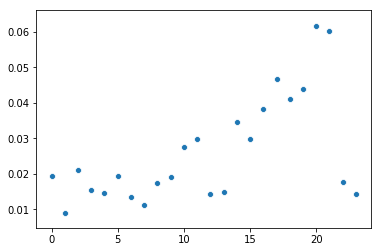

In [117]:
sns.scatterplot(y = x[:, 3, 3, -1], x = [x for x in range(24)])

In [73]:
np.argwhere(np.sum(x[:, :, :, -2:], (1, 2, 3)) > 256)

array([[ 0],
       [ 2],
       [ 4],
       [ 6],
       [ 8],
       [10],
       [12],
       [14],
       [16],
       [18],
       [20],
       [22]])

In [74]:
np.sum(x[:, :, :, -2:], (1, 2, 3))

array([512.      ,  17.028301, 512.      ,  15.295774, 512.      ,
        18.434525, 512.      ,  24.792126, 512.      ,  26.578152,
       512.      ,  44.0458  , 512.      ,  33.67505 , 512.      ,
        40.811874, 512.      ,  32.44155 , 512.      ,  37.157825,
       512.      ,  32.370224, 512.      ,  29.100075], dtype=float32)